<a href="https://colab.research.google.com/github/brian-lear/bootcamp_alura/blob/main/Brian_Lear_Alura_DS_Bootcamp_Projeto_04_(Time_Series).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contexto

Neste projeto do módulo 4 vamos trabalhar com a base de dados de casos de COVID-19, os impactos desta pandemia trouxe e ainda pode trazer consequências sem precedentes na sociedade moderna.

O foco deste projeto será analisar os casos de COVID-19 em uma perspectiva de Séries Temporais. Convidamos você a realizar uma análise dos dados, discutir suas estatísticas e desenvolver um modelo preditivo para prever o número de casos. Esse será os objetivos principais do projeto, mas sita-se livre para ir além do que estamos pedindo, o DATASUS tem muitas informações além dos número de casos e óbitos.

- Os dados atualizados oficialmente pelo Ministério do Saúde você acessa por este link.

- Dados relacionados a SRAG para enriquecer sua análise você encontra neste link

- Neste link você encontra várias outras informações relacionadas a COVID-19 para inspirar suas análises.

Bora mergulhar que esse projeto será desafiador!

# Apresentação

Meu nome é Brian Lear, comecei recentemente minha carreira em Data Science na Loft, uma proptech, como Decision Scientist, focado em levar uma melhor experiência para quem quer vender na nossa plataforma. Antes disso, ocupava um cargo na área de Analytics, ajudando a estruturar bases de dados e disponibilizando-as a outros Lofters para que tenham decisões mais data driven.

- [LinkedIn](https://www.linkedin.com/in/brian-lear-155bb745/)
- [GitHub](https://github.com/brian-lear)

# Abordagem

Vamos utilizar os modelos de Series Temporais para chegar na melhor previsão possível para os casos de COVID-19, à nível nacional.

Para tanto, vamos seguir três abordagens, comparar as três e definir qual o modelo com a melhor performance para a previsão dos casos. Vamos compara o SARIMA, AUTOARIMA e Prophet, usando como fator de decisão o [MASE](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error) (Mean absolute scaled error), que definirá a escolha do modelo. O MASE é um índice que mostra quanto a previsão é melhor do que somente prever o futuro assumindo o t = t-1.

# Importando libs e prep de dados

In [1]:
!pip install 'pmdarima'

     |████████████████████████████████| 1.5MB 5.3MB/s 
     |████████████████████████████████| 9.5MB 15.1MB/s 
     |████████████████████████████████| 2.1MB 51.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib.ticker as ticker

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

from pmdarima.arima import KPSSTest
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from fbprophet import Prophet

In [3]:
path_covid = '/content/drive/MyDrive/Colab_Notebooks/HIST_PAINEL_COVIDBR_20jan2021.csv'

In [4]:
df_covid = pd.read_csv(path_covid,sep=';')
df_covid.head(3)

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125.0,0,0,0,0,NaN,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,1,0,0,NaN,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,0,0,NaN,NaN,NaN


In [5]:
df_covid_br = df_covid.copy()
df_covid_br = df_covid_br.query("regiao == 'Brasil'")
df_covid_br = df_covid_br.drop(columns=['estado','municipio','coduf','codmun','codRegiaoSaude','nomeRegiaoSaude','interior/metropolitana'])
df_covid_br['data'] = pd.to_datetime(df_covid_br['data'])

date_list = df_covid_br['data']
date_list = date_list.to_list()
newlist = [x.strftime('%Y''-''%V') for x in date_list]
newlist = newlist[1:]
new_date = ['2021-03']
newlist = newlist + new_date

df_covid_br['weekly'] = newlist
df_covid_br['month'] = df_covid_br['data'].dt.month
df_covid_br['year'] = df_covid_br['data'].dt.year

df_covid_br.loc[df_covid_br['weekly'] == '2021-53','weekly'] = '2020-53'

df_covid_br.drop(304,inplace=True)
df_covid_br.drop(325,inplace=True)

df_covid_br = df_covid_br.reset_index(drop=True)
df_covid_br.head()

,regiao,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,weekly,month,year
0,Brasil,2020-02-25,9,210147125.0,0,0,0,0,NaN,NaN,2020-09,2,2020
1,Brasil,2020-02-26,9,210147125.0,1,1,0,0,NaN,NaN,2020-09,2,2020
2,Brasil,2020-02-27,9,210147125.0,1,0,0,0,NaN,NaN,2020-09,2,2020
3,Brasil,2020-02-28,9,210147125.0,1,0,0,0,NaN,NaN,2020-09,2,2020
4,Brasil,2020-02-29,9,210147125.0,2,1,0,0,NaN,NaN,2020-09,2,2020


# Analisando Sazonalidade

Abaixo podemos ver o gráfico de novos casos diários de COVID-19 à nível nacional. A sazonalidade de 7 dias é bem clara (por conta da maioria de casos do final de semana serem reportados na semana seguinte), e a variância não aparenta ser constante, tornando a série não estacionária.

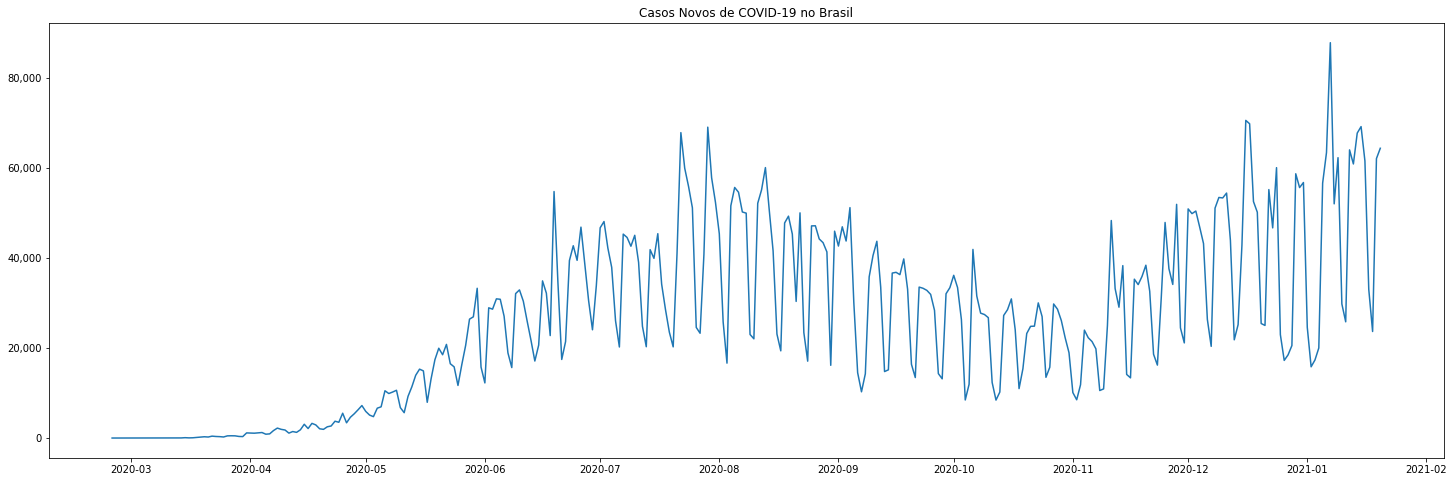

In [6]:
plt.figure(figsize=(25,8))
ax = sns.lineplot(data=df_covid_br,x='data',y='casosNovos')
plt.title('Casos Novos de COVID-19 no Brasil')
plt.ylabel(None)
plt.xlabel(None)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'));

In [7]:
# Verificando se o index é tratado como um DatetimeIndex para o correto funcionamento do seasonal_decompose

df_covid_br[['data','casosNovos']].set_index('data').info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 331 entries, 2020-02-25 to 2021-01-20
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   casosNovos  331 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


Com o seasonal decompose, podemos ver mais claramente o efeito sazonal e a tendência dos casos novos de COVID-19 no Brasil. Porém, nota-se que os resíduos (que neste caso são a subtração do valor real pelo valor na tendência e na sazonalidade) estão mais dispersos no último mês, o que pode indicar alguma mudança no comportamento padrão da série temporal.

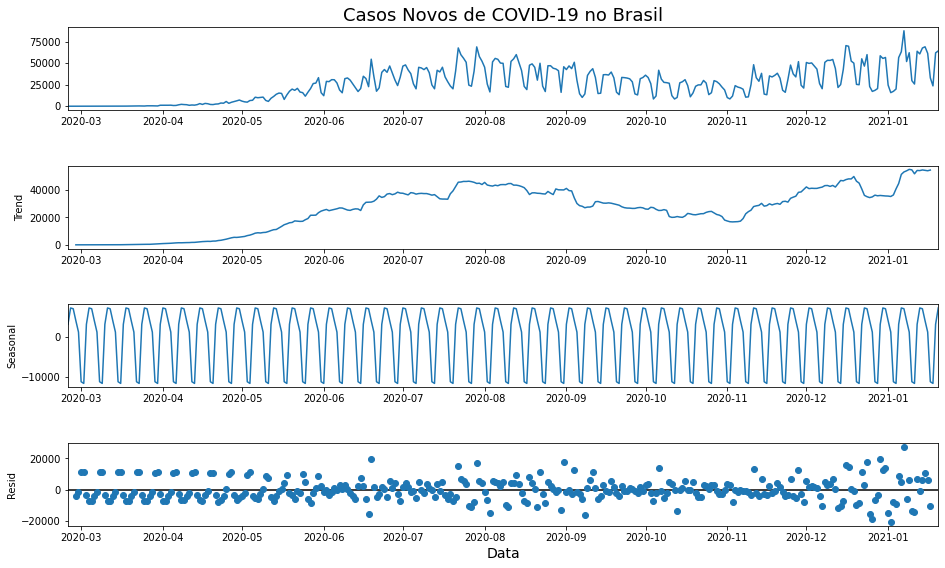

In [8]:
decompose = seasonal_decompose(df_covid_br[['data','casosNovos']].set_index('data'))

figure = decompose.plot()

figure.axes[0].set_title('Casos Novos de COVID-19 no Brasil', fontsize=18)
figure.set_size_inches(15,8)
figure.axes[3].set_xlabel('Data', fontsize=14)

figure;

# Modelos de Previsão

A previsão será feita por três frentes: ARIMA, AUTO_ARIMA e PROPHET. Para o ARIMA e AUTO_ARIMA, seguirei a lógica abaixo para a definição dos parâmetros ideais para os modelos, baseado no livro *Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 2021-01-21.*

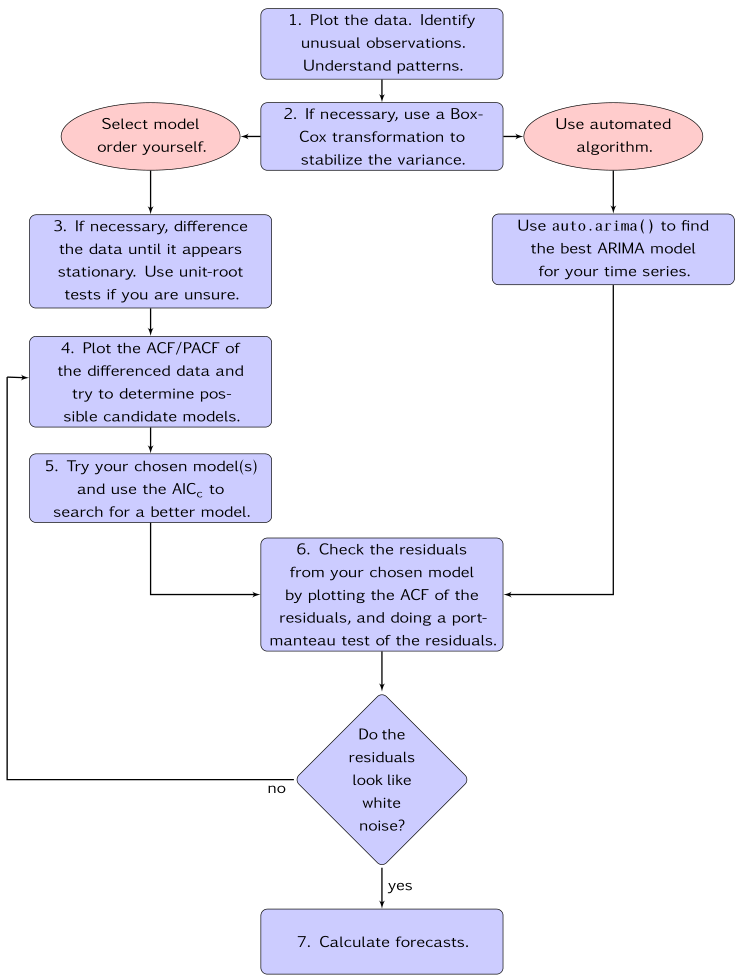

## SARIMA

A primeira tentativa será feita com o SARIMA, onde teremos que definir os parâmetros de forma manual, testar e comparar com outros parâmetros para encontrar o melhor, assim com analisando sinais no ACF, PACF e nos resíduos.

Conforme visto anteriormente, a série apresenta heterocedasticidade, e para usarmos o SARIMA, precisamos que a série seja estacionária. Para tanto, aplicaremos uma transformação logística visando corrigir essa heterocedasticidade.

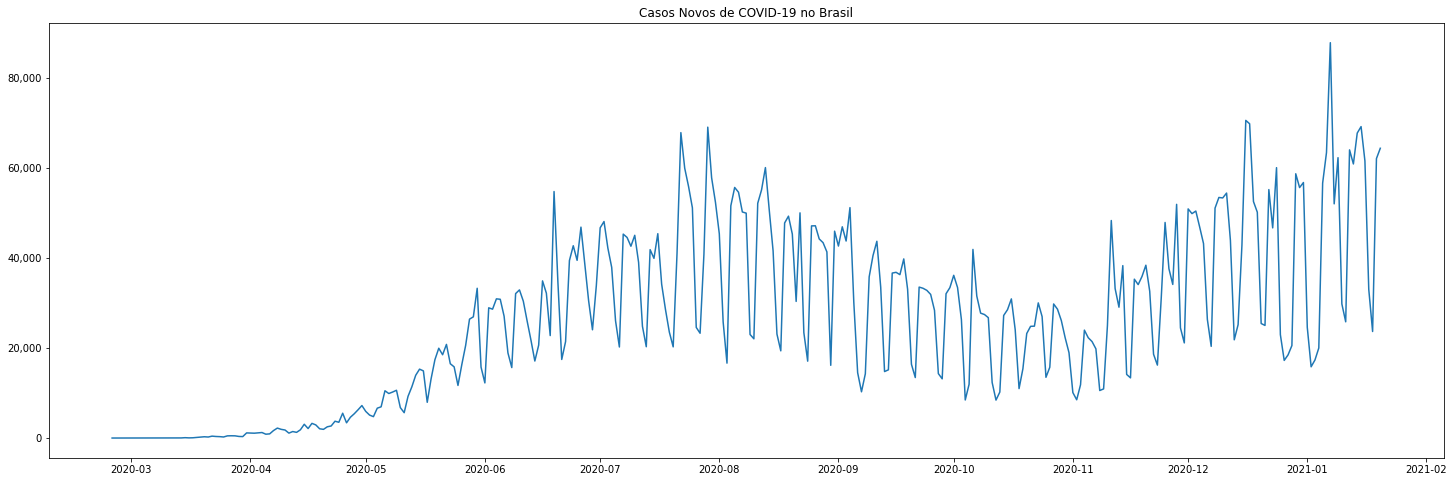

In [9]:
plt.figure(figsize=(25,8))
ax = sns.lineplot(data=df_covid_br,x='data',y='casosNovos')
plt.title('Casos Novos de COVID-19 no Brasil')
plt.ylabel(None)
plt.xlabel(None)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'));

In [10]:
# aplicando log na tentativa de tornar a série estacionária
df_covid_br_log = df_covid_br[['data','casosNovos']].copy()
df_covid_br_log['novos_casos_log'] = np.log(df_covid_br_log['casosNovos']+1)

Após a transformação logística, podemos ver que a variância se encontra mais constante.

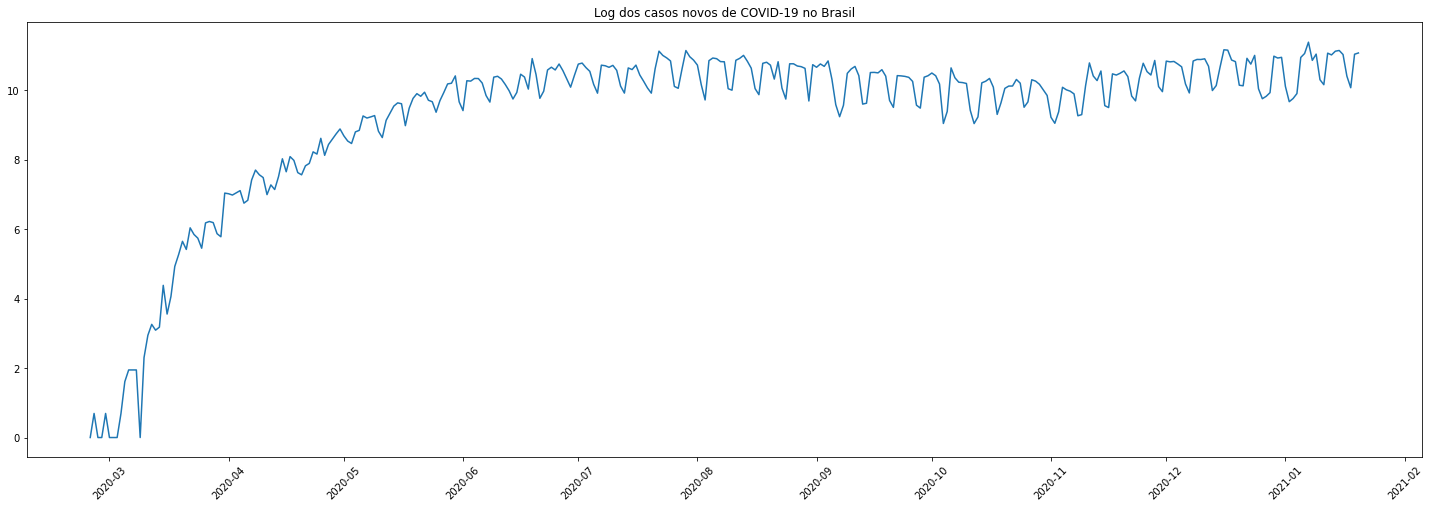

In [11]:
plt.figure(figsize=(25,8))
sns.lineplot(data=df_covid_br_log,x='data',y='novos_casos_log')
plt.title('Log dos casos novos de COVID-19 no Brasil')
plt.ylabel(None)
plt.xlabel(None)
plt.xticks(rotation = 45);

In [13]:
# separando dados de treino e teste, para evitar que ocorra algum vazamento de informações

dados_treino_covid = df_covid_br_log.query("data <= '2020-12-01'")
dados_teste_covid = df_covid_br_log.query("data > '2020-12-01'")

In [14]:
# separando dados de treino e teste defasados

dados_treino_covid_lag = df_covid_br_log.query("data <= '2020-11-30'")
dados_teste_covid_lag = df_covid_br_log.query("data > '2020-11-30'")

Baseado na literatura, para testar quantas graus de sazonalidade precisamos levar em conta, vou usar o teste KPSS.

In [15]:
n_kpss = ndiffs(dados_treino_covid['novos_casos_log'], test='kpss') 
print('n_kpss:', n_kpss)

n_kpss: 2


Vamos diferenciar em um e dois graus de sazonalidade e analisar os gráficos, para definir qual será o melhor para o SARIMA.

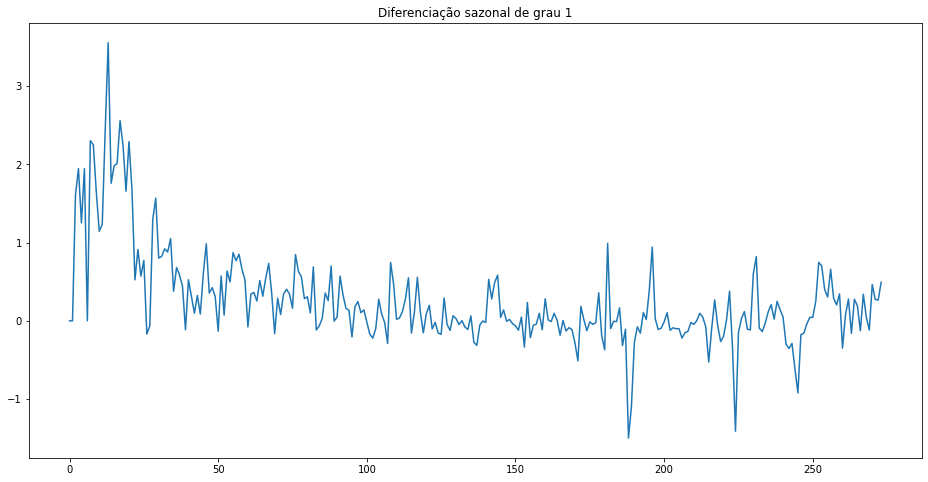

In [16]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced forecast
def inverse_difference(last_ob, value):
	return value + last_ob
 
# difference the dataset
dados_covid_seasonal = dados_treino_covid.copy()
seasonal_diff = difference(dados_covid_seasonal['novos_casos_log'], 7)
plt.figure(figsize=(16,8))
plt.plot(seasonal_diff)
plt.title('Diferenciação sazonal de grau 1')
plt.show()
df_seasonal = pd.DataFrame(seasonal_diff,columns=['seasonal_diff'])

Usando primeiro o grau um de dif sazonal, vamos agora diferenciar as séries para tornar-las mais estacionárias.

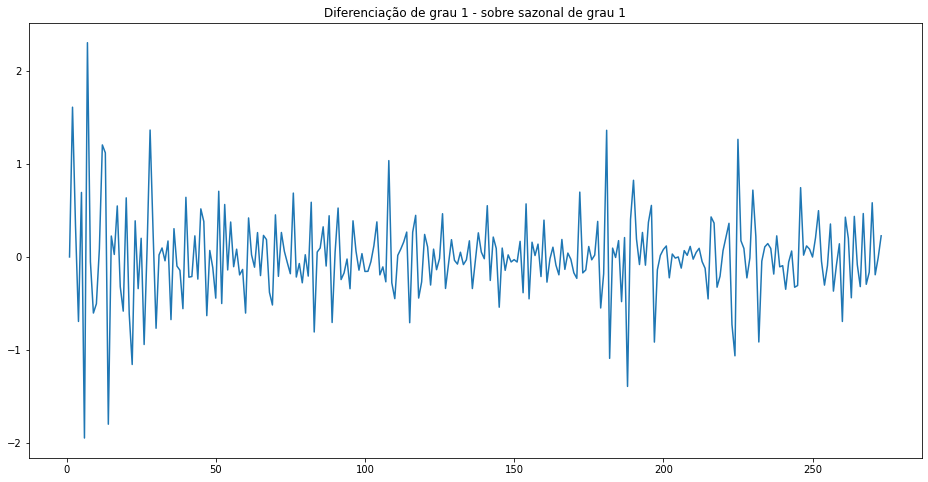

In [17]:
plt.figure(figsize=(16,8))
diff_1 = df_seasonal.diff()
plt.plot(diff_1)
plt.title('Diferenciação de grau 1 - sobre sazonal de grau 1')
plt.show()

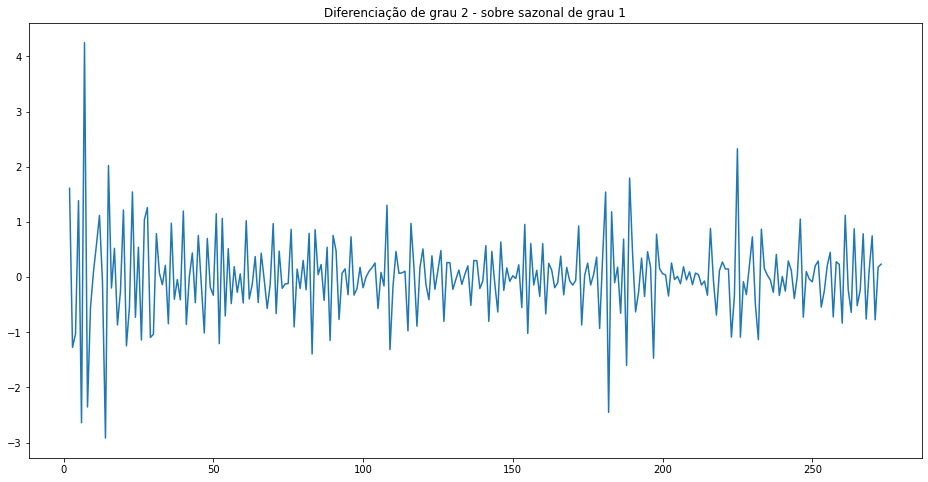

In [18]:
plt.figure(figsize=(16,8))
diff_2 = diff_1.diff()
plt.plot(diff_2)
plt.title('Diferenciação de grau 2 - sobre sazonal de grau 1')
plt.show()

Não parece que teremos ganhos se usarmos a diferenciação de grau 2, então no caso de seguir com a diferenciação sazonal de grau 1, a diferenciação será igualmente de grau 1.

Agora analisando a diferenciação sazonal de grau 2, para ver se chegamos a resultados relativamente melhores.

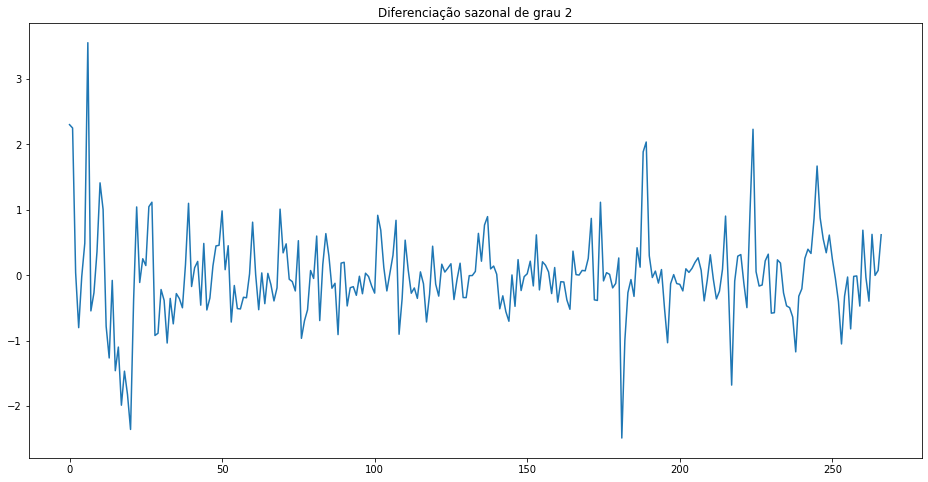

In [19]:
seasonal_diff_2 = difference(df_seasonal['seasonal_diff'], 7)
plt.figure(figsize=(16,8))
plt.plot(seasonal_diff_2)
plt.title('Diferenciação sazonal de grau 2')
plt.show()
df_seasonal_2 = pd.DataFrame(seasonal_diff_2,columns=['seasonal_diff'])

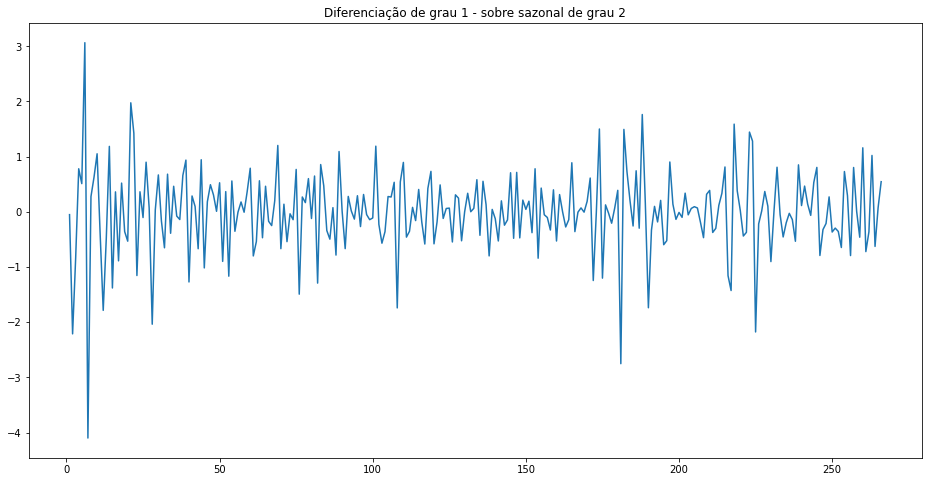

In [20]:
plt.figure(figsize=(16,8))
diff_1 = df_seasonal_2.diff()
plt.title('Diferenciação de grau 1 - sobre sazonal de grau 2')
plt.plot(diff_1)
plt.show()

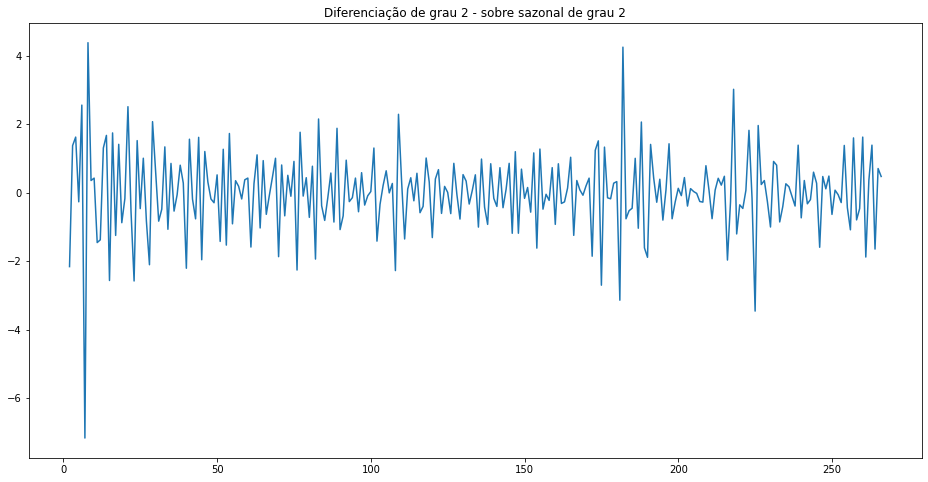

In [21]:
plt.figure(figsize=(16,8))
diff_2 = diff_1.diff()
plt.title('Diferenciação de grau 2 - sobre sazonal de grau 2')
plt.plot(diff_2)
plt.show()

Não vemos ganhos em usar o dado diferenciado no grau 2, então seguiremos com as diferenciação de grau 1 sobre a diferenciação sazonal de grau 1.

### ACF e PACF

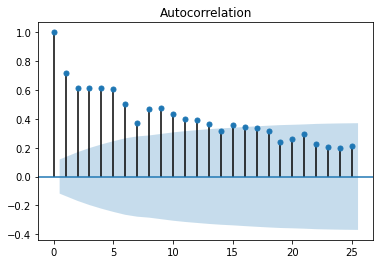

In [22]:
plot_acf(df_seasonal['seasonal_diff']);

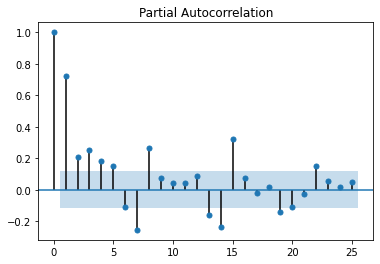

In [23]:
plot_pacf(df_seasonal['seasonal_diff']);

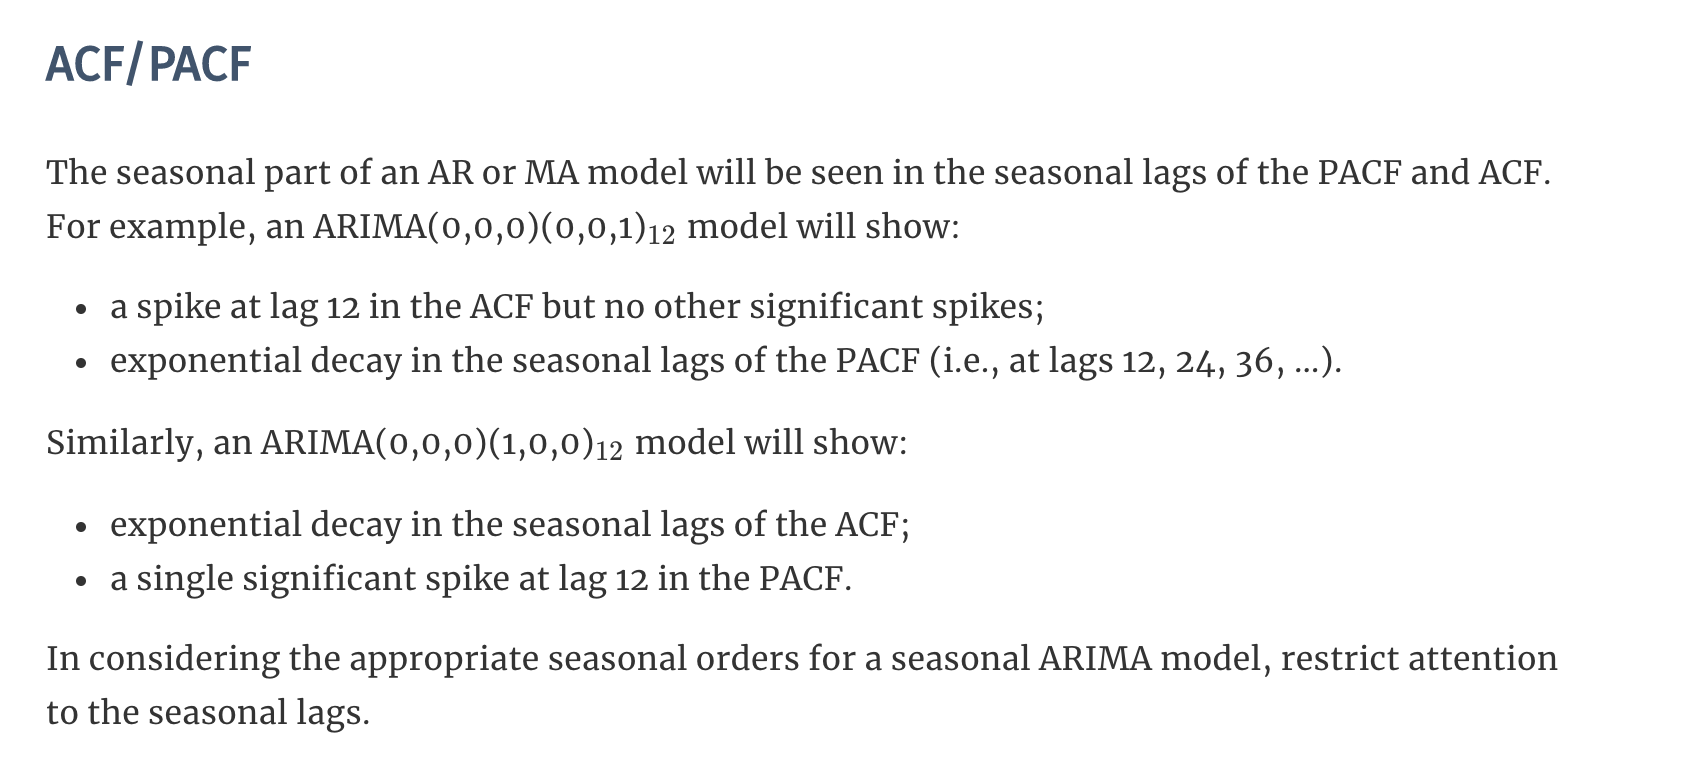

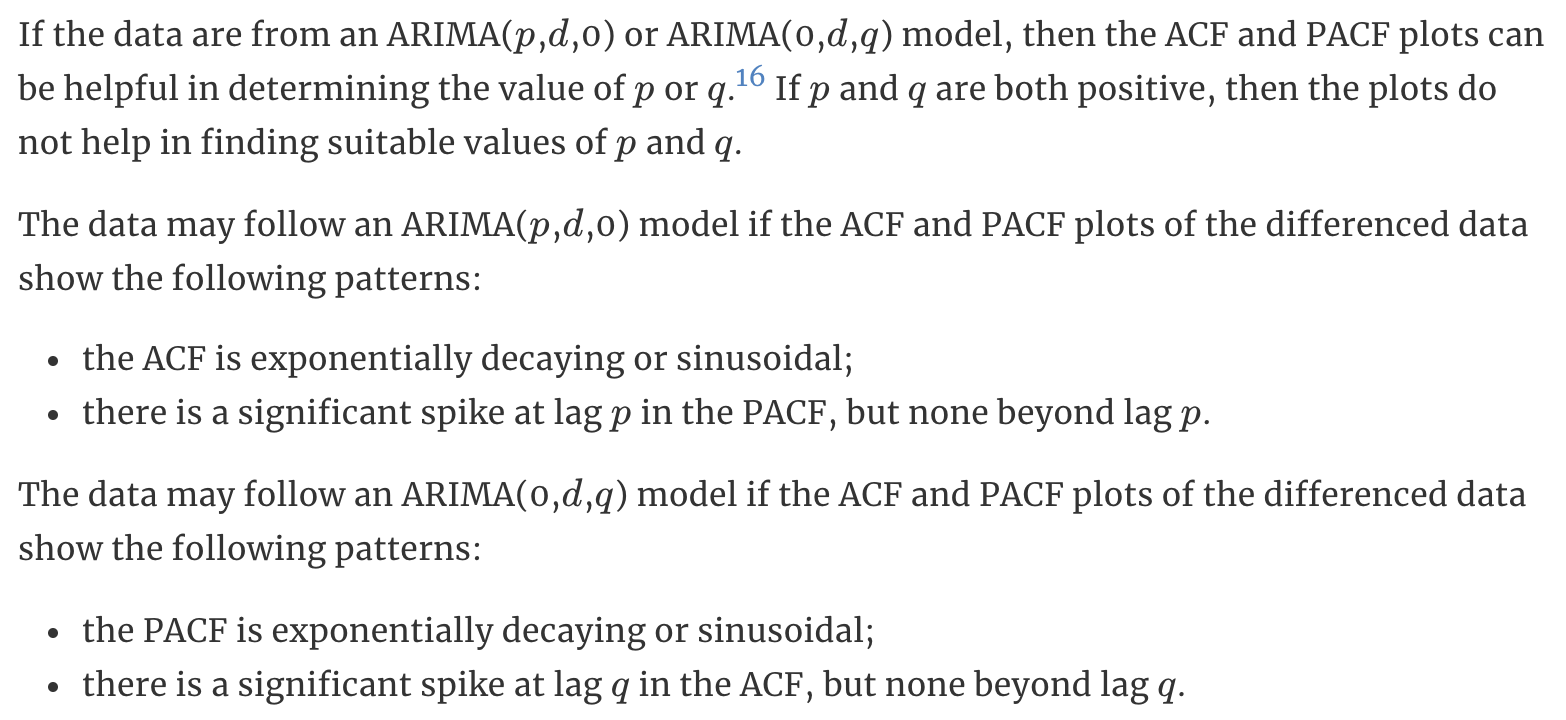

Analisando agora os gráficos de ACF e PACF, podemos ver que, dado a aparência exponencial na ACF e a queda brusca na PACF, nos leva a creer que é um caso de MA(2) (q=2 e p=0), com grau 2 de sazonalidade (Q).

### Testando os parâmetros (p,d,q)(P,D,Q)n

In [24]:
sarimax_data = dados_treino_covid.copy()
sarimax_data = sarimax_data[['data','novos_casos_log']]
sarimax_data = sarimax_data.set_index('data')
sarimax_data

,novos_casos_log
data,
2020-02-25,0.000000
2020-02-26,0.693147
2020-02-27,0.000000
2020-02-28,0.000000
2020-02-29,0.693147
...,...
2020-11-27,10.437961
2020-11-28,10.857517
2020-11-29,10.105162


**Nosso primeiro teste será então do modelo (0,1,2)(0,1,2)7**

In [25]:
order_1 = [0,1,2]
seasonal_order_1 =(0,1,2,7)

a = sm.tsa.statespace.SARIMAX(sarimax_data,order = order_1,seasonal_order=seasonal_order_1,freq='D')
modelo_sarima_treinado_1 = a.fit()
print(modelo_sarima_treinado_1.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                   novos_casos_log   No. Observations:                  281
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 7)   Log Likelihood                 -79.326
Date:                           Fri, 29 Jan 2021   AIC                            168.652
Time:                                   22:39:23   BIC                            186.700
Sample:                               02-25-2020   HQIC                           175.897
                                    - 12-01-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4553      0.038    -11.967      0.000      -0.530      -0.381
ma.L2         -0.0677      0.049     -1.381

In [26]:
a = modelo_sarima_treinado_1.summary().as_text().find('AIC')
AIC_1 = modelo_sarima_treinado_1.summary().as_text()[a+31:a+38]
AIC_1
print(f"{order_1}{seasonal_order_1} - AIC_1: {AIC_1}")

[0, 1, 2](0, 1, 2, 7) - AIC_1: 168.652


**Nosso segundo teste será então do modelo (0,1,2)(0,1,1)7**

In [27]:
order_2 = [0,1,2]
seasonal_order_2 = (0,1,1,7)

a = sm.tsa.statespace.SARIMAX(sarimax_data,order = order_2,seasonal_order=seasonal_order_2,freq='D')
modelo_sarima_treinado_2 = a.fit()
print(modelo_sarima_treinado_2.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                      SARIMAX Results                                      
Dep. Variable:                     novos_casos_log   No. Observations:                  281
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood                 -79.416
Date:                             Fri, 29 Jan 2021   AIC                            166.832
Time:                                     22:39:24   BIC                            181.270
Sample:                                 02-25-2020   HQIC                           172.628
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4538      0.037    -12.128      0.000      -0.527      -0.380
ma.L2         -0.0702      

In [28]:
a = modelo_sarima_treinado_2.summary().as_text().find('AIC')
AIC_2 = modelo_sarima_treinado_2.summary().as_text()[a+31:a+38]
AIC_2
print(f"{order_2}{seasonal_order_2} - AIC_2: {AIC_2}")

[0, 1, 2](0, 1, 1, 7) - AIC_2: 166.832


**Nosso terceiro teste será então do modelo (0,1,1)(0,1,2)7**

In [29]:
order_3 = [0,1,2]
seasonal_order_3 = (0,1,2,7)

a = sm.tsa.statespace.SARIMAX(sarimax_data,order = order_3,seasonal_order=seasonal_order_3,freq='D')
modelo_sarima_treinado_3 = a.fit()
print(modelo_sarima_treinado_3.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                   novos_casos_log   No. Observations:                  281
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 7)   Log Likelihood                 -79.326
Date:                           Fri, 29 Jan 2021   AIC                            168.652
Time:                                   22:39:25   BIC                            186.700
Sample:                               02-25-2020   HQIC                           175.897
                                    - 12-01-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4553      0.038    -11.967      0.000      -0.530      -0.381
ma.L2         -0.0677      0.049     -1.381

In [30]:
a = modelo_sarima_treinado_3.summary().as_text().find('AIC')
AIC_3 = modelo_sarima_treinado_3.summary().as_text()[a+31:a+38]
AIC_3
print(f"{order_3}{seasonal_order_3} - AIC_3: {AIC_3}")

[0, 1, 2](0, 1, 2, 7) - AIC_3: 168.652


**Nosso quarto teste será então do modelo (0,1,1)(0,1,1)7**

In [31]:
order_4 = [0,1,1]
seasonal_order_4 = (0,1,1,7)

a = sm.tsa.statespace.SARIMAX(sarimax_data,order = order_4,seasonal_order=seasonal_order_4,freq='D')
modelo_sarima_treinado_4 = a.fit()
print(modelo_sarima_treinado_4.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                     SARIMAX Results                                     
Dep. Variable:                   novos_casos_log   No. Observations:                  281
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                 -80.087
Date:                           Fri, 29 Jan 2021   AIC                            166.174
Time:                                   22:39:25   BIC                            177.003
Sample:                               02-25-2020   HQIC                           170.521
                                    - 12-01-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5028      0.037    -13.709      0.000      -0.575      -0.431
ma.S.L7       -0.8052      0.053    -15.108

In [32]:
a = modelo_sarima_treinado_4.summary().as_text().find('AIC')
AIC_4 = modelo_sarima_treinado_4.summary().as_text()[a+31:a+38]
AIC_4

'166.174'

**Nosso quinto teste será então do modelo (0,1,1)(0,1,0)7**

In [33]:
order_5 = [0,1,1]
seasonal_order_5 = (0,1,0,7)

a = sm.tsa.statespace.SARIMAX(sarimax_data,order = order_5,seasonal_order=seasonal_order_5,freq='D')
modelo_sarima_treinado = a.fit()
print(modelo_sarima_treinado.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    novos_casos_log   No. Observations:                  281
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 7)   Log Likelihood                -143.953
Date:                            Fri, 29 Jan 2021   AIC                            291.905
Time:                                    22:39:25   BIC                            299.124
Sample:                                02-25-2020   HQIC                           294.803
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6273      0.033    -19.158      0.000      -0.691      -0.563
sigma2         0.1678      0.009   

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [34]:
a = modelo_sarima_treinado.summary().as_text().find('AIC')
AIC_5 = modelo_sarima_treinado.summary().as_text()[a+31:a+38]
AIC_5

'291.905'

**Nosso sexto teste será então do modelo (0,1,1)(0,1,0)7**

In [35]:
order_6 = [0,1,0]
seasonal_order_6 = (0,1,1,7)

a = sm.tsa.statespace.SARIMAX(sarimax_data,order = order_6,seasonal_order=seasonal_order_6,freq='D')
modelo_sarima_treinado = a.fit()
print(modelo_sarima_treinado.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                      SARIMAX Results                                      
Dep. Variable:                     novos_casos_log   No. Observations:                  281
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -106.072
Date:                             Fri, 29 Jan 2021   AIC                            216.144
Time:                                     22:39:26   BIC                            223.363
Sample:                                 02-25-2020   HQIC                           219.042
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.8578      0.046    -18.479      0.000      -0.949      -0.767
sigma2         0.1231      

In [36]:
a = modelo_sarima_treinado.summary().as_text().find('AIC')
AIC_6 = modelo_sarima_treinado.summary().as_text()[a+31:a+38]
AIC_6

'216.144'

**Comparativo**

Analisando os AIC, vemos que a métrica melhora à medida que diminuímos os paraâmetros, porém quando zeramos eles, sobe muito. O ponto ótimo parece ser o (0, 1, 1)(0, 1, 1, 7) - AIC_4: 166.174.

In [37]:
print(f"{order_1}{seasonal_order_1} - AIC_1: {AIC_1}")
print(f"{order_2}{seasonal_order_2} - AIC_2: {AIC_2}")
print(f"{order_3}{seasonal_order_3} - AIC_3: {AIC_3}")
print(f"{order_4}{seasonal_order_4} - AIC_4: {AIC_4}")
print(f"{order_5}{seasonal_order_5} - AIC_5: {AIC_5}")
print(f"{order_6}{seasonal_order_6} - AIC_6: {AIC_6}")

[0, 1, 2](0, 1, 2, 7) - AIC_1: 168.652
[0, 1, 2](0, 1, 1, 7) - AIC_2: 166.832
[0, 1, 2](0, 1, 2, 7) - AIC_3: 168.652
[0, 1, 1](0, 1, 1, 7) - AIC_4: 166.174
[0, 1, 1](0, 1, 0, 7) - AIC_5: 291.905
[0, 1, 0](0, 1, 1, 7) - AIC_6: 216.144


Agora testaremos os resíduos para termos mais indícios de qual modelo utilizar para fazer a previsão dos novos casos de COVID-19 no Brasil.

### Previsão

In [38]:
previsao_sarima_1 = modelo_sarima_treinado_1.forecast(84)
previsao_sarima_1 = previsao_sarima_1.to_frame()
previsao_sarima_1 = previsao_sarima_1.rename(columns={'predicted_mean':'previsao_sarimax_1'})

,previsao_sarimax_1
2021-02-19,12.201848
2021-02-20,12.232389
2021-02-21,11.498123
2021-02-22,11.442028
2021-02-23,12.173873


In [39]:
previsao_sarima_2 = modelo_sarima_treinado_2.forecast(84)
previsao_sarima_2 = previsao_sarima_2.to_frame()
previsao_sarima_2 = previsao_sarima_2.rename(columns={'predicted_mean':'previsao_sarimax_2'})

,previsao_sarimax_2
2021-02-19,12.132670
2021-02-20,12.155781
2021-02-21,11.421666
2021-02-22,11.368299
2021-02-23,12.096919


In [40]:
previsao_sarima_3 = modelo_sarima_treinado_3.forecast(84)
previsao_sarima_3 = previsao_sarima_3.to_frame()
previsao_sarima_3 = previsao_sarima_3.rename(columns={'predicted_mean':'previsao_sarimax_3'})

,previsao_sarimax_3
2021-02-19,12.201848
2021-02-20,12.232389
2021-02-21,11.498123
2021-02-22,11.442028
2021-02-23,12.173873


In [41]:
previsao_sarima_4 = modelo_sarima_treinado_4.forecast(84)
previsao_sarima_4 = previsao_sarima_4.to_frame()
previsao_sarima_4 = previsao_sarima_4.rename(columns={'predicted_mean':'previsao_sarimax_4'})

,previsao_sarimax_4
2021-02-19,12.135791
2021-02-20,12.155215
2021-02-21,11.421369
2021-02-22,11.369114
2021-02-23,12.096224


In [42]:
# juntando a previsão com os dados de teste, para calcular os resíduos

dados_teste_covid = dados_teste_covid.merge(previsao_sarima_1,left_on='data',right_index=True)
dados_teste_covid = dados_teste_covid.merge(previsao_sarima_2,left_on='data',right_index=True)
dados_teste_covid = dados_teste_covid.merge(previsao_sarima_3,left_on='data',right_index=True)
dados_teste_covid = dados_teste_covid.merge(previsao_sarima_4,left_on='data',right_index=True)

dados_teste_covid['residuals_sarimax_1'] = dados_teste_covid['novos_casos_log'] - dados_teste_covid['previsao_sarimax_1']
dados_teste_covid['residuals_sarimax_2'] = dados_teste_covid['novos_casos_log'] - dados_teste_covid['previsao_sarimax_2']
dados_teste_covid['residuals_sarimax_3'] = dados_teste_covid['novos_casos_log'] - dados_teste_covid['previsao_sarimax_3']
dados_teste_covid['residuals_sarimax_4'] = dados_teste_covid['novos_casos_log'] - dados_teste_covid['previsao_sarimax_4']

dados_teste_covid.head()

,data,casosNovos,novos_casos_log,previsao_sarimax_1,previsao_sarimax_2,previsao_sarimax_3,previsao_sarimax_4,residuals_sarimax_1,residuals_sarimax_2,residuals_sarimax_3,residuals_sarimax_4
281,2020-12-02,49863,10.817055,11.054975,11.053468,11.054975,11.049116,-0.237920,-0.236413,-0.237920,-0.232062
282,2020-12-03,50434,10.828441,10.938786,10.934945,10.938786,10.945950,-0.110345,-0.106504,-0.110345,-0.117509
283,2020-12-04,46884,10.755453,10.910177,10.904536,10.910177,10.916036,-0.154724,-0.149083,-0.154724,-0.160583
284,2020-12-05,43209,10.673827,10.924284,10.927647,10.924284,10.935461,-0.250457,-0.253820,-0.250457,-0.261633
285,2020-12-06,26363,10.179755,10.190496,10.193532,10.190496,10.201614,-0.010741,-0.013777,-0.010741,-0.021860


#### Previsão defasada - para cálculo do MASE

In [43]:
sarimax_data_lag = dados_treino_covid_lag.copy()
sarimax_data_lag = sarimax_data_lag[['data','novos_casos_log']]
sarimax_data_lag = sarimax_data_lag.set_index('data')
sarimax_data_lag

order_4 = [0,1,1]
seasonal_order_4 = (0,1,1,7)

a = sm.tsa.statespace.SARIMAX(sarimax_data_lag,order = order_4,seasonal_order=seasonal_order_4,freq='D')
modelo_sarima_treinado_4 = a.fit()

previsao_sarima_4_lag = modelo_sarima_treinado_4.forecast(1)
previsao_sarima_4_lag = previsao_sarima_4_lag.to_frame()
previsao_sarima_4_lag = previsao_sarima_4_lag.rename(columns={0:'previsao_sarimax_4_lag'})
previsao_sarima_4_lag.reset_index(drop=True,inplace=True)
previsao_sarima_4_lag.index += 281

dados_teste_covid = dados_teste_covid.merge(previsao_sarima_4_lag,how='left',left_index=True,right_index=True)
dados_teste_covid['previsao_sarimax_4_lag'] = previsao_sarima_4_lag['previsao_sarimax_4_lag'].values[0]
dados_teste_covid['residuals_sarimax_4_lag'] = dados_teste_covid['novos_casos_log'] - dados_teste_covid['previsao_sarimax_4_lag']
dados_teste_covid.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



,data,casosNovos,novos_casos_log,previsao_sarimax_1,previsao_sarimax_2,previsao_sarimax_3,previsao_sarimax_4,residuals_sarimax_1,residuals_sarimax_2,residuals_sarimax_3,residuals_sarimax_4,previsao_sarimax_4_lag,residuals_sarimax_4_lag
281,2020-12-02,49863,10.817055,11.054975,11.053468,11.054975,11.049116,-0.237920,-0.236413,-0.237920,-0.232062,10.659296,0.157759
282,2020-12-03,50434,10.828441,10.938786,10.934945,10.938786,10.945950,-0.110345,-0.106504,-0.110345,-0.117509,10.659296,0.169145
283,2020-12-04,46884,10.755453,10.910177,10.904536,10.910177,10.916036,-0.154724,-0.149083,-0.154724,-0.160583,10.659296,0.096158
284,2020-12-05,43209,10.673827,10.924284,10.927647,10.924284,10.935461,-0.250457,-0.253820,-0.250457,-0.261633,10.659296,0.014532
285,2020-12-06,26363,10.179755,10.190496,10.193532,10.190496,10.201614,-0.010741,-0.013777,-0.010741,-0.021860,10.659296,-0.479541


#### Analisando os resíduos

Usando o ACF e o teste de Ljung-Box, veremos se os resíduos são um White Noise ou se eles possuem alguma autocorrelação, o que pode ser um problema para o modelo.

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:533: FutureWarning:

The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning:

The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.



[2.06854544e-05 2.24556398e-06 3.48862895e-06 9.44672059e-06
 1.44291717e-05 7.46333662e-06 5.25161290e-08 2.29335985e-08
 4.43390504e-08 1.03185894e-07 2.47036505e-07 5.50436117e-07
 1.10664794e-06 2.19700810e-06 3.06520242e-06 5.25473344e-06
 7.34334906e-06 1.18777639e-05 1.56462918e-05 9.98439174e-06
 1.19323690e-05 6.04181221e-06 4.59711549e-06]


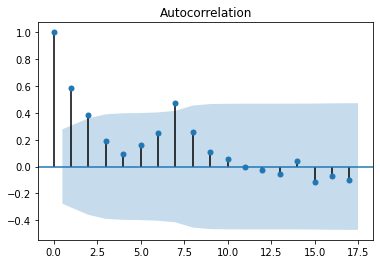

In [44]:
plot_acf(dados_teste_covid['residuals_sarimax_1']);

_,pvalue = acorr_ljungbox(dados_teste_covid['residuals_sarimax_1'])

print(pvalue)

[3.00362875e-05 4.55957954e-06 8.80896507e-06 2.59817377e-05
 4.48886890e-05 2.77223038e-05 2.37748684e-07 1.19391466e-07
 2.42777576e-07 5.68144432e-07 1.29471527e-06 2.69820336e-06
 5.01084729e-06 9.85178655e-06 1.21929632e-05 1.95027746e-05
 2.51047341e-05 3.86576571e-05 5.01199568e-05 3.29883921e-05
 4.00561370e-05 2.11102907e-05 1.69510767e-05]


/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:533: FutureWarning:

The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning:

The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.



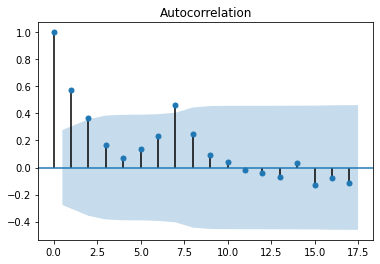

In [45]:
plot_acf(dados_teste_covid['residuals_sarimax_2']);

_,pvalue = acorr_ljungbox(dados_teste_covid['residuals_sarimax_2'])

print(pvalue)

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:533: FutureWarning:

The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning:

The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.



[2.06854544e-05 2.24556398e-06 3.48862895e-06 9.44672059e-06
 1.44291717e-05 7.46333662e-06 5.25161290e-08 2.29335985e-08
 4.43390504e-08 1.03185894e-07 2.47036505e-07 5.50436117e-07
 1.10664794e-06 2.19700810e-06 3.06520242e-06 5.25473344e-06
 7.34334906e-06 1.18777639e-05 1.56462918e-05 9.98439174e-06
 1.19323690e-05 6.04181221e-06 4.59711549e-06]


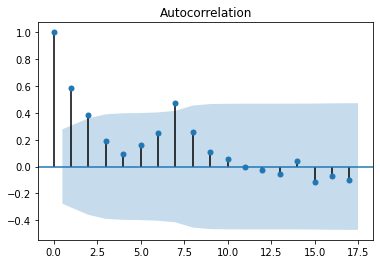

In [46]:
plot_acf(dados_teste_covid['residuals_sarimax_3']);

_,pvalue = acorr_ljungbox(dados_teste_covid['residuals_sarimax_3'])

print(pvalue)

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:533: FutureWarning:

The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning:

The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.



[2.98969142e-05 4.63921169e-06 9.27212538e-06 2.76603690e-05
 4.81485712e-05 2.96063506e-05 2.60336012e-07 1.30267159e-07
 2.65219325e-07 6.23123388e-07 1.41149918e-06 2.93144901e-06
 5.43150025e-06 1.06758199e-05 1.32155279e-05 2.10680993e-05
 2.66994458e-05 4.07103003e-05 5.28942146e-05 3.53607611e-05
 4.29398318e-05 2.32234924e-05 1.86697238e-05]


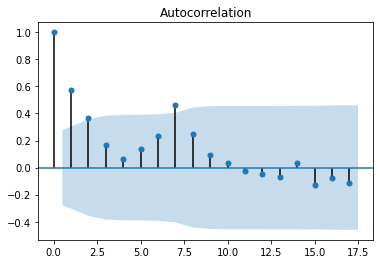

In [47]:
plot_acf(dados_teste_covid['residuals_sarimax_4']);

_,pvalue = acorr_ljungbox(dados_teste_covid['residuals_sarimax_4'])

print(pvalue)

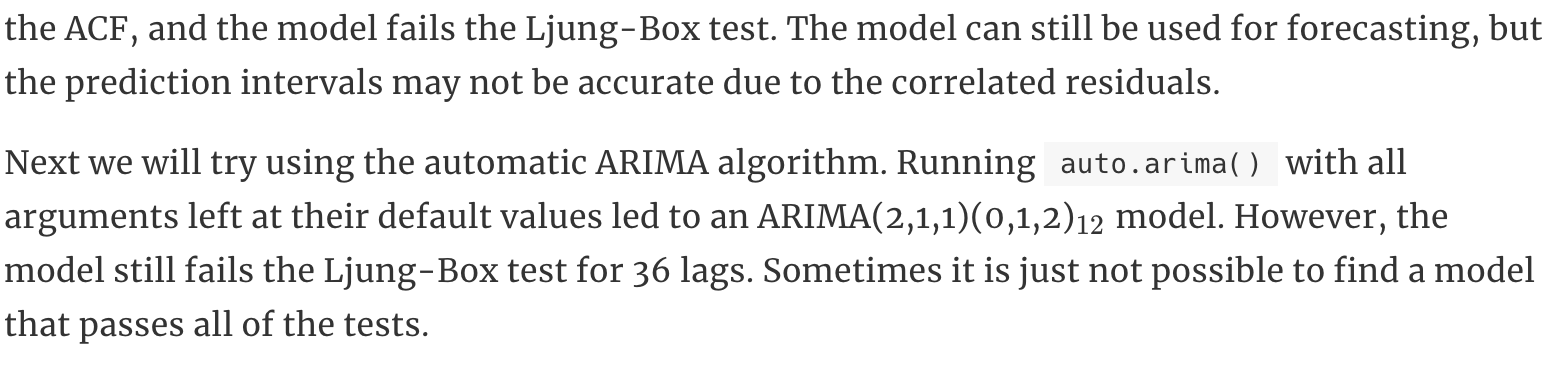

No teste de ACF e Ljung-Box, os resíduos não passaram em nenhum dos 4 casos, o que mostraria que os resíduos não são White Noise. Porém, conforme o trecho acima, nem sempre o modelo passa em todos os testes, e temos que seguir com o que performou melhor. Neste caso, continuamos com o (0, 1, 1)(0, 1, 1, 7).

### MASE SARIMA

In [48]:
# Para calcularmos o MASE, fazemos MAE(t)/MAE(t-1). Quanto menor, melhor. Porém, MASE acima de 1 mostra que o modelo não performa melhor do que utilizar o dado de t-1 e assumir que ele continua constante até o final da previsão.

MASE_sarima = mean_absolute_error(dados_teste_covid['novos_casos_log'],dados_teste_covid['previsao_sarimax_4'])/mean_absolute_error(dados_teste_covid['novos_casos_log'],dados_teste_covid['previsao_sarimax_4_lag'])
MASE_sarima

1.1141752722851224

### Plot da previsão

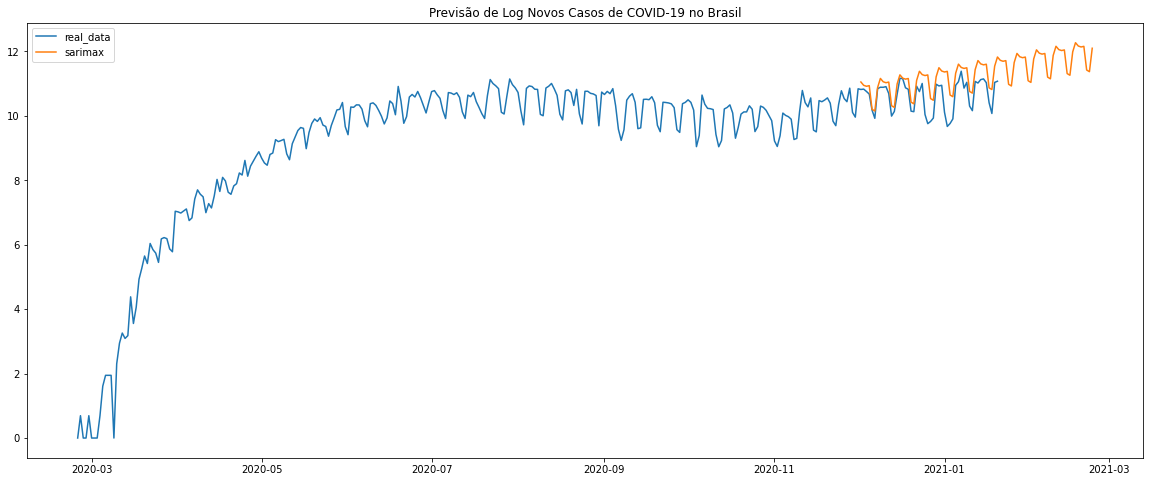

In [49]:
previsao_sarima_4.rename(columns={'previsao_sarimax_4':'novos_casos_log'},inplace=True)

plt.figure(figsize=(20,8))
sns.lineplot(data=df_covid_br_log,x='data',y='novos_casos_log',label='real_data')
sns.lineplot(data=previsao_sarima_4,x=previsao_sarima_4.index,y='novos_casos_log',label='sarimax')
plt.title('Previsão de Log Novos Casos de COVID-19 no Brasil')
plt.ylabel(None)
plt.xlabel(None);

## Autoarima

Agora, vamos testar a efetividade do Autoarima, que não necessita de tantos passos como o modelo SARIMA.

In [50]:
modelo_autoarima = auto_arima(dados_treino_covid['novos_casos_log'].values, error_action="ignore",trace=True,m=7)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[7]             : AIC=inf, Time=1.38 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=579.008, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=459.104, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=inf, Time=0.44 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=532.724, Time=0.03 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=439.772, Time=0.19 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=385.422, Time=0.70 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=383.871, Time=0.36 sec
 ARIMA(1,2,0)(0,0,1)[7]             : AIC=479.541, Time=0.12 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=385.222, Time=0.65 sec
 ARIMA(1,2,0)(0,0,2)[7]             : AIC=478.624, Time=0.23 sec
 ARIMA(1,2,0)(2,0,2)[7]             : AIC=inf, Time=0.99 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=490.455, Time=0.27 sec
 ARIMA(2,2,0)(1,0,1)[7]             : AIC=319.411, Time=0.49 sec
 ARIMA(2,2,0)(0,0,1)[7]             : AIC=427.802, Time=0.1

In [51]:
modelo_autoarima_lag = auto_arima(dados_treino_covid_lag['novos_casos_log'].values, error_action="ignore",trace=True,m=7)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[7]             : AIC=inf, Time=1.33 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=575.667, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=456.160, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=inf, Time=0.37 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=527.661, Time=0.03 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=438.241, Time=0.19 sec
 ARIMA(1,2,0)(2,0,1)[7]             : AIC=384.601, Time=0.64 sec
 ARIMA(1,2,0)(1,0,1)[7]             : AIC=383.022, Time=0.42 sec
 ARIMA(1,2,0)(0,0,1)[7]             : AIC=475.157, Time=0.10 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=384.405, Time=0.81 sec
 ARIMA(1,2,0)(0,0,2)[7]             : AIC=474.785, Time=0.22 sec
 ARIMA(1,2,0)(2,0,2)[7]             : AIC=inf, Time=0.89 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=489.277, Time=0.28 sec
 ARIMA(2,2,0)(1,0,1)[7]             : AIC=319.332, Time=0.50 sec
 ARIMA(2,2,0)(0,0,1)[7]             : AIC=425.545, Time=0.1

O modelo identificado pelo AUTOARIMA é bem diferente do encontrado pelo SARIMA, sendo o (4,2,1)(2,0,2)[7], com um AIC de 167.919.

### Previsão

In [52]:
previsao_autoarima = modelo_autoarima.predict(n_periods=84)
previsao_autoarima = pd.DataFrame(previsao_autoarima, columns = ['previsao_autoarima_log'])
previsao_autoarima.index = previsao_sarima_4.index 
previsao_autoarima.tail()

,previsao_autoarima_log
2021-02-19,13.034524
2021-02-20,13.035389
2021-02-21,12.435155
2021-02-22,12.420047
2021-02-23,13.061298


In [53]:
# juntando a previsão com os dados de teste, para calcular os resíduos

dados_teste_covid = dados_teste_covid.merge(previsao_autoarima,left_on='data',right_index=True)

dados_teste_covid['residuals_autoarima_log'] = dados_teste_covid['novos_casos_log'] - dados_teste_covid['previsao_autoarima_log']

dados_teste_covid.head()

,data,casosNovos,novos_casos_log,previsao_sarimax_1,previsao_sarimax_2,previsao_sarimax_3,previsao_sarimax_4,residuals_sarimax_1,residuals_sarimax_2,residuals_sarimax_3,residuals_sarimax_4,previsao_sarimax_4_lag,residuals_sarimax_4_lag,previsao_autoarima_log,residuals_autoarima_log
281,2020-12-02,49863,10.817055,11.054975,11.053468,11.054975,11.049116,-0.237920,-0.236413,-0.237920,-0.232062,10.659296,0.157759,11.105197,-0.288142
282,2020-12-03,50434,10.828441,10.938786,10.934945,10.938786,10.945950,-0.110345,-0.106504,-0.110345,-0.117509,10.659296,0.169145,10.973505,-0.145065
283,2020-12-04,46884,10.755453,10.910177,10.904536,10.910177,10.916036,-0.154724,-0.149083,-0.154724,-0.160583,10.659296,0.096158,10.899141,-0.143687
284,2020-12-05,43209,10.673827,10.924284,10.927647,10.924284,10.935461,-0.250457,-0.253820,-0.250457,-0.261633,10.659296,0.014532,10.976105,-0.302277
285,2020-12-06,26363,10.179755,10.190496,10.193532,10.190496,10.201614,-0.010741,-0.013777,-0.010741,-0.021860,10.659296,-0.479541,10.226949,-0.047194


#### Previsão defasada

In [54]:
previsao_autoarima_lag = modelo_autoarima_lag.predict(n_periods=1)
previsao_autoarima_lag = pd.DataFrame(previsao_autoarima_lag, columns = ['previsao_autoarima_lag'])
previsao_autoarima_lag.index += 281
previsao_autoarima_lag.tail()

,previsao_autoarima_lag
281,10.594435


In [55]:
dados_teste_covid = dados_teste_covid.merge(previsao_autoarima_lag,how='left',left_index=True,right_index=True)
dados_teste_covid['previsao_autoarima_lag'] = previsao_autoarima_lag['previsao_autoarima_lag'].values[0]
dados_teste_covid['residuals_autoarima_lag'] = dados_teste_covid['novos_casos_log'] - dados_teste_covid['previsao_autoarima_lag']
dados_teste_covid.head()

,data,casosNovos,novos_casos_log,previsao_sarimax_1,previsao_sarimax_2,previsao_sarimax_3,previsao_sarimax_4,residuals_sarimax_1,residuals_sarimax_2,residuals_sarimax_3,residuals_sarimax_4,previsao_sarimax_4_lag,residuals_sarimax_4_lag,previsao_autoarima_log,residuals_autoarima_log,previsao_autoarima_lag,residuals_autoarima_lag
281,2020-12-02,49863,10.817055,11.054975,11.053468,11.054975,11.049116,-0.237920,-0.236413,-0.237920,-0.232062,10.659296,0.157759,11.105197,-0.288142,10.594435,0.222620
282,2020-12-03,50434,10.828441,10.938786,10.934945,10.938786,10.945950,-0.110345,-0.106504,-0.110345,-0.117509,10.659296,0.169145,10.973505,-0.145065,10.594435,0.234006
283,2020-12-04,46884,10.755453,10.910177,10.904536,10.910177,10.916036,-0.154724,-0.149083,-0.154724,-0.160583,10.659296,0.096158,10.899141,-0.143687,10.594435,0.161018
284,2020-12-05,43209,10.673827,10.924284,10.927647,10.924284,10.935461,-0.250457,-0.253820,-0.250457,-0.261633,10.659296,0.014532,10.976105,-0.302277,10.594435,0.079392
285,2020-12-06,26363,10.179755,10.190496,10.193532,10.190496,10.201614,-0.010741,-0.013777,-0.010741,-0.021860,10.659296,-0.479541,10.226949,-0.047194,10.594435,-0.414680


#### Analisando os resíduos

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:533: FutureWarning:

The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning:

The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.



[2.58756474e-07 4.90474164e-10 7.82571545e-11 4.34610778e-11
 8.26886977e-12 4.64421353e-13 8.47223696e-16 7.20911680e-17
 4.26709644e-17 6.90596724e-17 1.74295147e-16 4.01437980e-16
 1.06284451e-15 1.94507009e-15 5.34816688e-15 1.37319495e-14
 3.47058576e-14 8.37638506e-14 1.60939942e-13 1.40304429e-13
 1.45280476e-13 6.23521992e-14 3.46985990e-14]


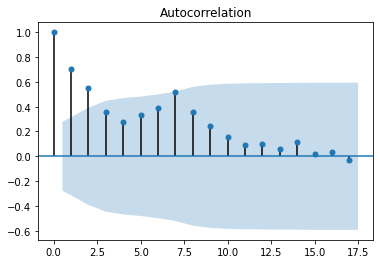

In [56]:
plot_acf(dados_teste_covid['residuals_autoarima_log']);

_,pvalue = acorr_ljungbox(dados_teste_covid['residuals_autoarima_log'])

print(pvalue)

Com os resíduos temos resultados similares aos do SARIMA, o que não nos leva a uma preferência clara entre os modelos.

### Plot da previsão

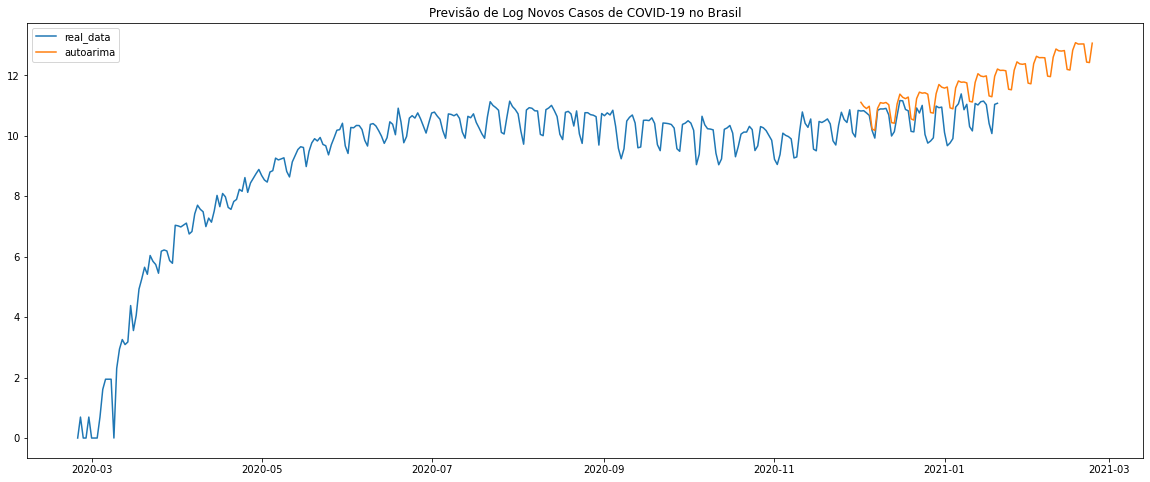

In [57]:
previsao_autoarima.rename(columns={'previsao_autoarima_log':'novos_casos_log'},inplace=True)

plt.figure(figsize=(20,8))
sns.lineplot(data=df_covid_br_log,x='data',y='novos_casos_log',label='real_data')
sns.lineplot(data=previsao_autoarima,x=previsao_autoarima.index,y='novos_casos_log',label='autoarima')
plt.title('Previsão de Log Novos Casos de COVID-19 no Brasil')
plt.ylabel(None)
plt.xlabel(None);

### MASE

Vamos usar o MASE para comparar os dois modelos e identificar qual performa melhor entre o SARIMA e o AUTOARIMA.

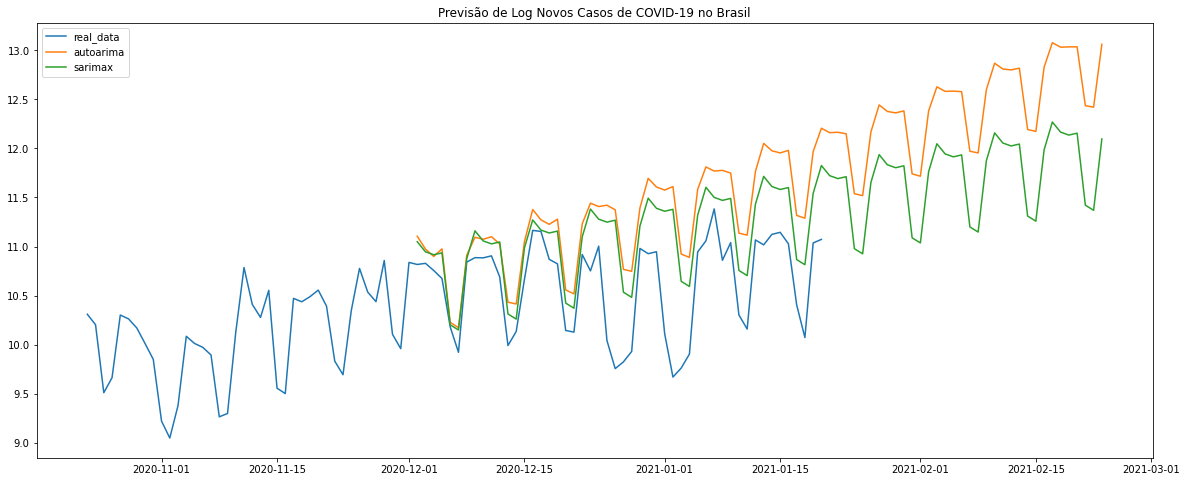

In [58]:
previsao_autoarima.rename(columns={'previsao_autoarima_log':'novos_casos_log'},inplace=True)

plt.figure(figsize=(20,8))
sns.lineplot(data=df_covid_br_log[-90:],x='data',y='novos_casos_log',label='real_data')
sns.lineplot(data=previsao_autoarima[-90:],x=previsao_autoarima[-90:].index,y='novos_casos_log',label='autoarima')
sns.lineplot(data=previsao_sarima_4[-90:],x=previsao_sarima_4[-90:].index,y='novos_casos_log',label='sarimax')
plt.title('Previsão de Log Novos Casos de COVID-19 no Brasil')
plt.ylabel(None)
plt.xlabel(None);

In [60]:
MASE_autoarima = mean_absolute_error(dados_teste_covid['novos_casos_log'],dados_teste_covid['previsao_autoarima_log'])/mean_absolute_error(dados_teste_covid['novos_casos_log'],dados_teste_covid['previsao_autoarima_lag'])

print(f"MASE Autoarima = {MASE_autoarima}")
print(f"MASE Sarima = {MASE_sarima}")

MASE Autoarima = 1.5118553226174445
MASE Sarima = 1.1141752722851224


Por enquanto, SARIMA está performando melhor, com um MASE e AIC menor, mesmo todos os casos falhando no teste dos residuos. Vamos comparar com o Prophet

## Prophet

Vamos analisar a performance do Prophet para o caso da Transformação Logarítimica, e comparar com os SARIMA e AUTOARIMA.

### Previsão Log Novos Casos

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


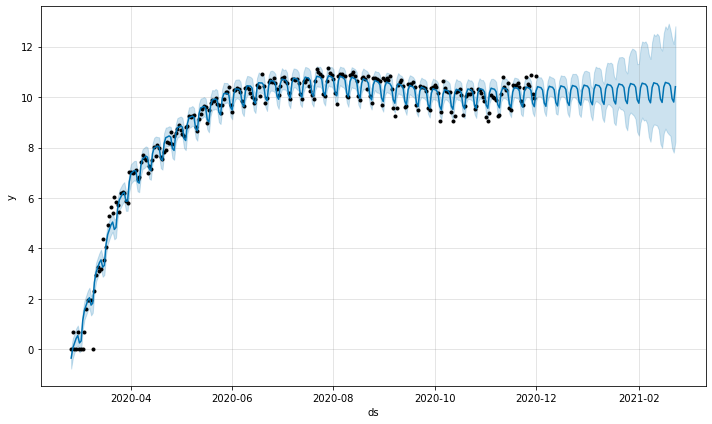

In [61]:
dados_treino_prophet_log = dados_treino_covid[['data','novos_casos_log']].copy()
dados_treino_prophet_log.rename({'data':'ds','novos_casos_log':'y'},axis=1,inplace=True)

prophet_model = Prophet(seasonality_mode='additive')
prophet_dados_treino = dados_treino_prophet_log[['ds','y']]

model_prophet_trained = prophet_model.fit(prophet_dados_treino)

future = model_prophet_trained.make_future_dataframe(periods = 84,freq = 'D')

prophet_outcome_log = model_prophet_trained.predict(future)

model_prophet_trained.plot(prophet_outcome_log);

In [62]:
prophet_outcome_log.rename(columns={'yhat':'prediction_prophet_log'},inplace=True)
prophet_outcome_log = prophet_outcome_log[['ds','prediction_prophet_log']]
prophet_outcome_log.tail()

,ds,prediction_prophet_log
360,2021-02-19,10.540659
361,2021-02-20,10.441981
362,2021-02-21,9.936350
363,2021-02-22,9.801564
364,2021-02-23,10.410795


In [63]:
dados_teste_covid = dados_teste_covid.merge(prophet_outcome_log,left_on='data',right_on='ds')
dados_teste_covid = dados_teste_covid.drop(columns=['ds'])
dados_teste_covid.head()

,data,casosNovos,novos_casos_log,previsao_sarimax_1,previsao_sarimax_2,previsao_sarimax_3,previsao_sarimax_4,residuals_sarimax_1,residuals_sarimax_2,residuals_sarimax_3,residuals_sarimax_4,previsao_sarimax_4_lag,residuals_sarimax_4_lag,previsao_autoarima_log,residuals_autoarima_log,previsao_autoarima_lag,residuals_autoarima_lag,prediction_prophet_log
0,2020-12-02,49863,10.817055,11.054975,11.053468,11.054975,11.049116,-0.237920,-0.236413,-0.237920,-0.232062,10.659296,0.157759,11.105197,-0.288142,10.594435,0.222620,10.414081
1,2020-12-03,50434,10.828441,10.938786,10.934945,10.938786,10.945950,-0.110345,-0.106504,-0.110345,-0.117509,10.659296,0.169145,10.973505,-0.145065,10.594435,0.234006,10.388707
2,2020-12-04,46884,10.755453,10.910177,10.904536,10.910177,10.916036,-0.154724,-0.149083,-0.154724,-0.160583,10.659296,0.096158,10.899141,-0.143687,10.594435,0.161018,10.372390
3,2020-12-05,43209,10.673827,10.924284,10.927647,10.924284,10.935461,-0.250457,-0.253820,-0.250457,-0.261633,10.659296,0.014532,10.976105,-0.302277,10.594435,0.079392,10.273711
4,2020-12-06,26363,10.179755,10.190496,10.193532,10.190496,10.201614,-0.010741,-0.013777,-0.010741,-0.021860,10.659296,-0.479541,10.226949,-0.047194,10.594435,-0.414680,9.768081


#### Previsao defasada

In [64]:
dados_treino_prophet_lag = dados_treino_covid_lag[['data','novos_casos_log']].copy()
dados_treino_prophet_lag.rename({'data':'ds','novos_casos_log':'y'},axis=1,inplace=True)

prophet_model = Prophet(seasonality_mode='additive')
prophet_dados_treino_lag = dados_treino_prophet_lag[['ds','y']]

model_prophet_trained_lag = prophet_model.fit(prophet_dados_treino_lag)

future = model_prophet_trained_lag.make_future_dataframe(periods = 1,freq = 'D')

prophet_outcome_lag = model_prophet_trained_lag.predict(future)

# model_prophet_trained_lag.plot(prophet_outcome_log);

prophet_outcome_lag.rename(columns={'yhat':'prediction_prophet_lag'},inplace=True)
prophet_outcome_lag = prophet_outcome_lag[['ds','prediction_prophet_lag']]
prophet_outcome_lag = prophet_outcome_lag.tail(1)
prophet_outcome_lag.index -=280
prophet_outcome_lag.drop(columns=['ds'],inplace=True)
prophet_outcome_lag

dados_teste_covid = dados_teste_covid.merge(prophet_outcome_lag,how='left',left_index=True,right_index=True)
dados_teste_covid['prediction_prophet_lag'] = prophet_outcome_lag.values[0][0]
dados_teste_covid.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,data,casosNovos,novos_casos_log,previsao_sarimax_1,previsao_sarimax_2,previsao_sarimax_3,previsao_sarimax_4,residuals_sarimax_1,residuals_sarimax_2,residuals_sarimax_3,residuals_sarimax_4,previsao_sarimax_4_lag,residuals_sarimax_4_lag,previsao_autoarima_log,residuals_autoarima_log,previsao_autoarima_lag,residuals_autoarima_lag,prediction_prophet_log,prediction_prophet_lag
0,2020-12-02,49863,10.817055,11.054975,11.053468,11.054975,11.049116,-0.237920,-0.236413,-0.237920,-0.232062,10.659296,0.157759,11.105197,-0.288142,10.594435,0.222620,10.414081,10.191929
1,2020-12-03,50434,10.828441,10.938786,10.934945,10.938786,10.945950,-0.110345,-0.106504,-0.110345,-0.117509,10.659296,0.169145,10.973505,-0.145065,10.594435,0.234006,10.388707,10.191929
2,2020-12-04,46884,10.755453,10.910177,10.904536,10.910177,10.916036,-0.154724,-0.149083,-0.154724,-0.160583,10.659296,0.096158,10.899141,-0.143687,10.594435,0.161018,10.372390,10.191929
3,2020-12-05,43209,10.673827,10.924284,10.927647,10.924284,10.935461,-0.250457,-0.253820,-0.250457,-0.261633,10.659296,0.014532,10.976105,-0.302277,10.594435,0.079392,10.273711,10.191929
4,2020-12-06,26363,10.179755,10.190496,10.193532,10.190496,10.201614,-0.010741,-0.013777,-0.010741,-0.021860,10.659296,-0.479541,10.226949,-0.047194,10.594435,-0.414680,9.768081,10.191929


#### Analisando os resíduos

In [65]:
dados_teste_covid['residuals_prophet_lag'] = dados_teste_covid['novos_casos_log'] - dados_teste_covid['prediction_prophet_lag']

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:533: FutureWarning:

The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning:

The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.



[2.50037758e-04 1.18681445e-03 5.27895596e-05 8.46422394e-07
 1.98569761e-06 4.51030842e-07 1.61147740e-11 2.79876507e-12
 5.81476565e-12 1.32116670e-13 1.31715771e-15 1.57384963e-15
 2.94039626e-15 2.97079552e-16 6.60811457e-16 6.96596548e-16
 1.25475948e-17 6.43386312e-19 1.63028095e-18 1.43157929e-18
 9.39105242e-20 1.73179464e-19 1.71218115e-19]


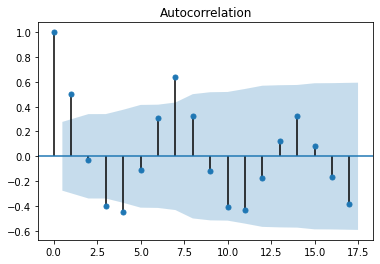

In [66]:
plot_acf(dados_teste_covid['residuals_prophet_lag']);

_,pvalue = acorr_ljungbox(dados_teste_covid['residuals_prophet_lag'])

print(pvalue)

Assim, como no caso do SARIMA e AUTOARIMA,os resíduos não tem total ausência de autocorrelação, o que nos da indícios que não são White Noite.

### MASE

In [67]:
MASE_prophet = mean_absolute_error(dados_teste_covid['novos_casos_log'],dados_teste_covid['prediction_prophet_log'])/mean_absolute_error(dados_teste_covid['novos_casos_log'],dados_teste_covid['prediction_prophet_lag'])

print(f"MASE Prophet = {MASE_prophet}")
print(f"MASE Autoarima = {MASE_autoarima}")
print(f"MASE Sarima = {MASE_sarima}")

MASE Prophet = 0.8734556276320485
MASE Autoarima = 1.5118553226174445
MASE Sarima = 1.1141752722851224


## Comparando os Modelos de Previsão

Plotando a previsão dos 3 modelos, vemos que o Prophet é bem mais conservador, enquanto o SARIMA e o AUTOARIMA consideram uma crescente no número de casos novos.

Aparentemente o Prophet utiliza melhor a tendencia geral da curva ao longo do tempo, porém o SARIMA captura melhor o aumento das últimas semanas, mesmo que com uma projeção um tanto negativa.

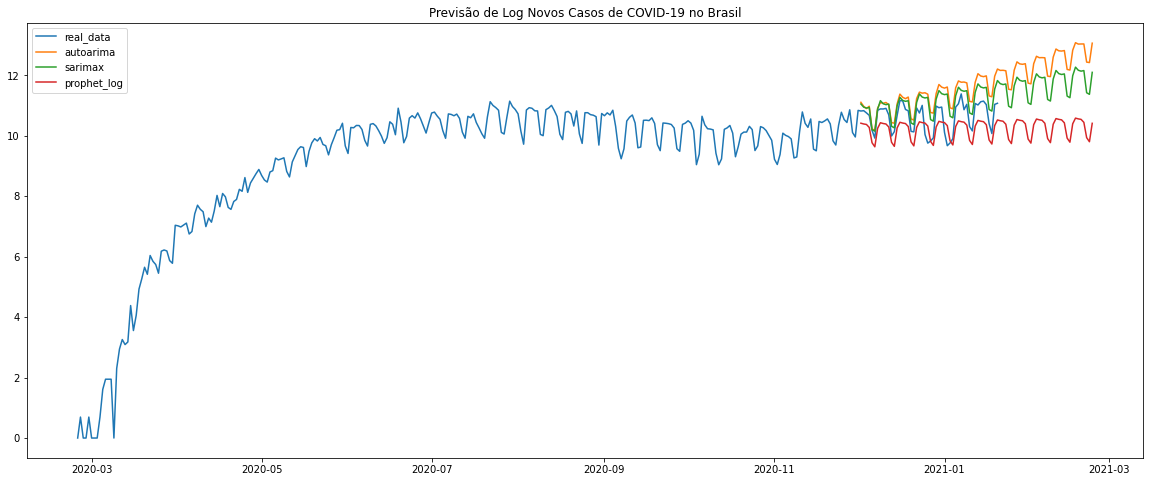

In [69]:
previsao_autoarima.rename(columns={'previsao_autoarima_log':'novos_casos_log'},inplace=True)

plt.figure(figsize=(20,8))
sns.lineplot(data=df_covid_br_log[:],x='data',y='novos_casos_log',label='real_data')
sns.lineplot(data=previsao_autoarima,x=previsao_autoarima.index,y='novos_casos_log',label='autoarima')
sns.lineplot(data=previsao_sarima_4,x=previsao_sarima_4.index,y='novos_casos_log',label='sarimax')
sns.lineplot(data=prophet_outcome_log[-84:],x='ds',y='prediction_prophet_log',label='prophet_log')
plt.title('Previsão de Log Novos Casos de COVID-19 no Brasil')
plt.ylabel(None)
plt.xlabel(None);

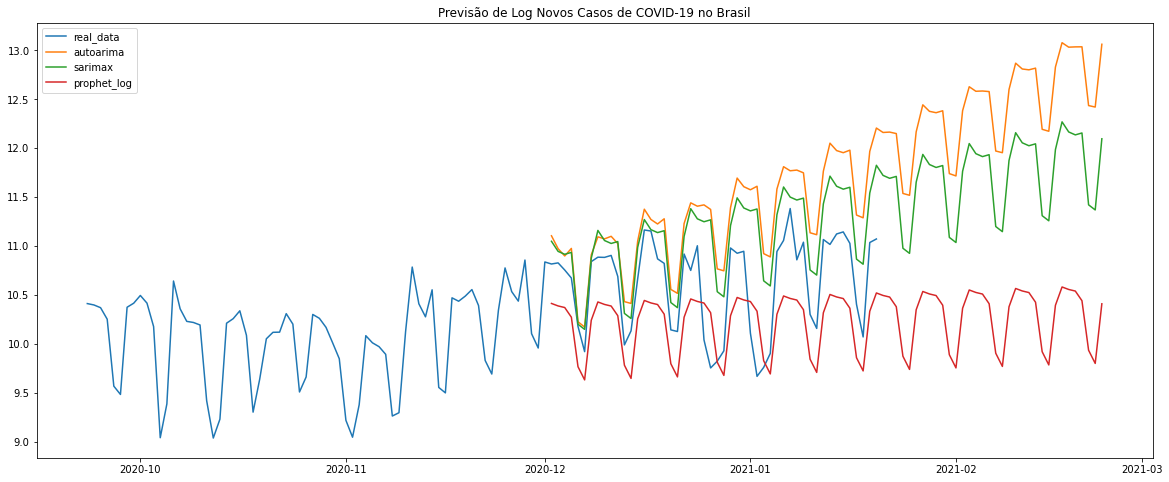

In [70]:
previsao_autoarima.rename(columns={'previsao_autoarima_log':'novos_casos_log'},inplace=True)

plt.figure(figsize=(20,8))
sns.lineplot(data=df_covid_br_log[-120:],x='data',y='novos_casos_log',label='real_data')
sns.lineplot(data=previsao_autoarima,x=previsao_autoarima.index,y='novos_casos_log',label='autoarima')
sns.lineplot(data=previsao_sarima_4,x=previsao_sarima_4.index,y='novos_casos_log',label='sarimax')
sns.lineplot(data=prophet_outcome_log[-84:],x='ds',y='prediction_prophet_log',label='prophet_log')
plt.title('Previsão de Log Novos Casos de COVID-19 no Brasil')
plt.ylabel(None)
plt.xlabel(None);

Podemos ver que o modelo com o menor MASE é o Prophet, sendo então a melhor opção para utilizar como modelo de previsão.

In [ ]:
print(f"MASE Prophet = {MASE_prophet}")
print(f"MASE Autoarima = {MASE_autoarima}")
print(f"MASE Sarima = {MASE_sarima}")

# Modelo final de previsão

Para termos o modelo final, treinarei o modelo com todos os dados, dado que já escolhemos o Prophet usando treino e teste para validar a eficácia do modelo.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


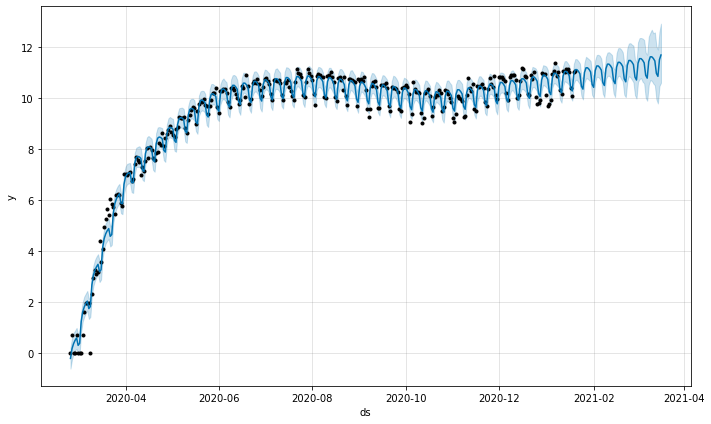

In [77]:
df_covid_br_prophet = df_covid_br_log[['data','novos_casos_log']].copy()
df_covid_br_prophet.rename({'data':'ds','novos_casos_log':'y'},axis=1,inplace=True)

prophet_model = Prophet(seasonality_mode='additive')
prophet_dados_treino = df_covid_br_prophet[['ds','y']]

model_prophet_trained = prophet_model.fit(prophet_dados_treino)

future = model_prophet_trained.make_future_dataframe(periods = 56,freq = 'D')

prophet_outcome_log = model_prophet_trained.predict(future)

model_prophet_trained.plot(prophet_outcome_log);

In [81]:
prophet_outcome_log.rename(columns={'yhat':'prediction_prophet_log'},inplace=True)
prophet_outcome_log = prophet_outcome_log[['ds','prediction_prophet_log']]
prophet_outcome_log.tail()

,ds,prediction_prophet_log
382,2021-03-13,11.455072
383,2021-03-14,10.966430
384,2021-03-15,10.851178
385,2021-03-16,11.504809
386,2021-03-17,11.689066


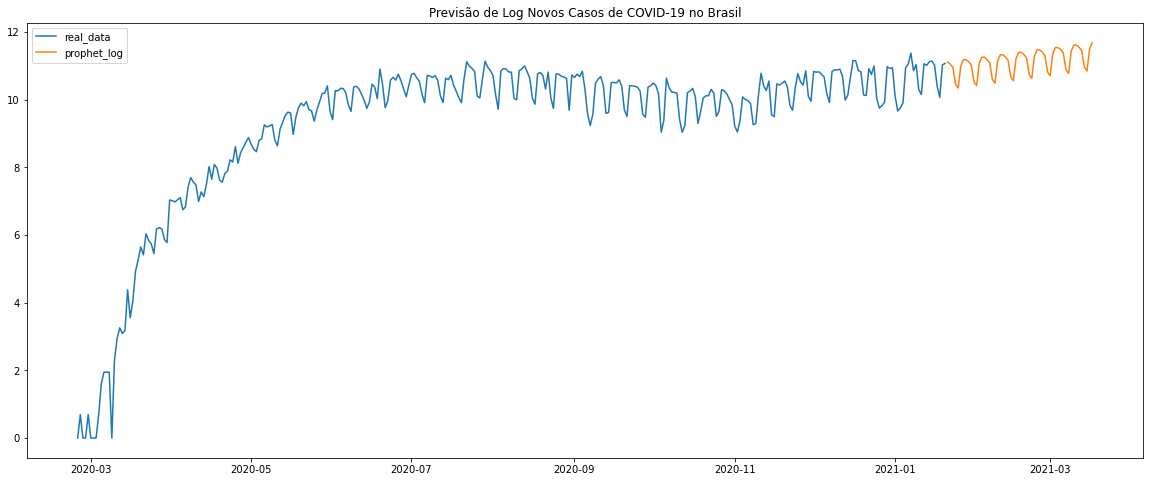

In [85]:
previsao_autoarima.rename(columns={'previsao_autoarima_log':'novos_casos_log'},inplace=True)

plt.figure(figsize=(20,8))
sns.lineplot(data=df_covid_br_log[:],x='data',y='novos_casos_log',label='real_data')
sns.lineplot(data=prophet_outcome_log[-56:],x='ds',y='prediction_prophet_log',label='prophet_log')
plt.title('Previsão de Log Novos Casos de COVID-19 no Brasil')
plt.ylabel(None)
plt.xlabel(None);

# Conclusão

A COVID-19, por ser um fenômeno recente no mundo e no Brasil, ainda não apresenta uma sazonalidade de periodos maiores, como de meses do ano (padrão encontrado em outras doenças respiratórias). A sazonalidade que encontramos se refere provavelmente à forma com a qual os dados são notificados e transmitidos, com uma queda no final de semana e acumulo desses casos ao longo da semana. 

O modelo que apresentou a melhor performance na previsão dos novos casos de COVID-19 foi o Prophet. Porém, vale ressaltar que a pandemia da COVID-19 é algo com muitos fatores exógenos e baixa previsibilidade, e possívelmente precisariamos de modelos mais robustos para uma previsão dessa complexidade, com mais variáveis.